In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import collections
import glob
from binarization import binary_threshold
from birdeyeperspective import birdeyeview
from cameracalibration import camera_calibration,undistort


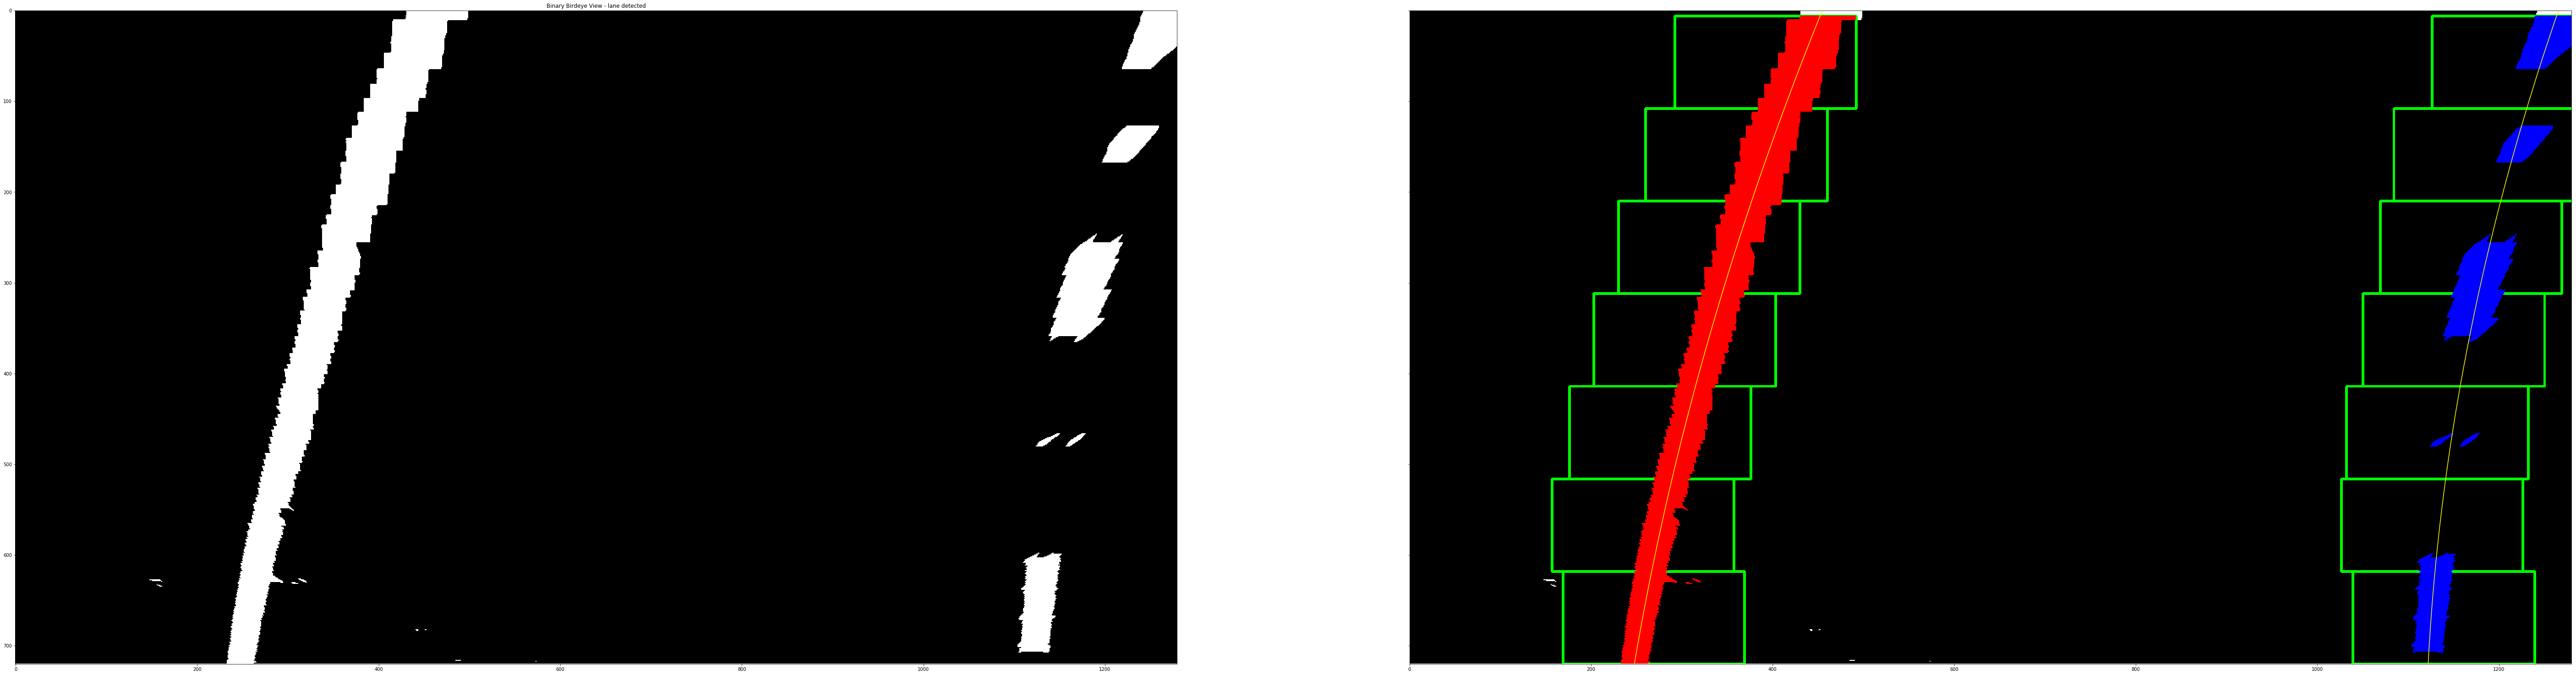

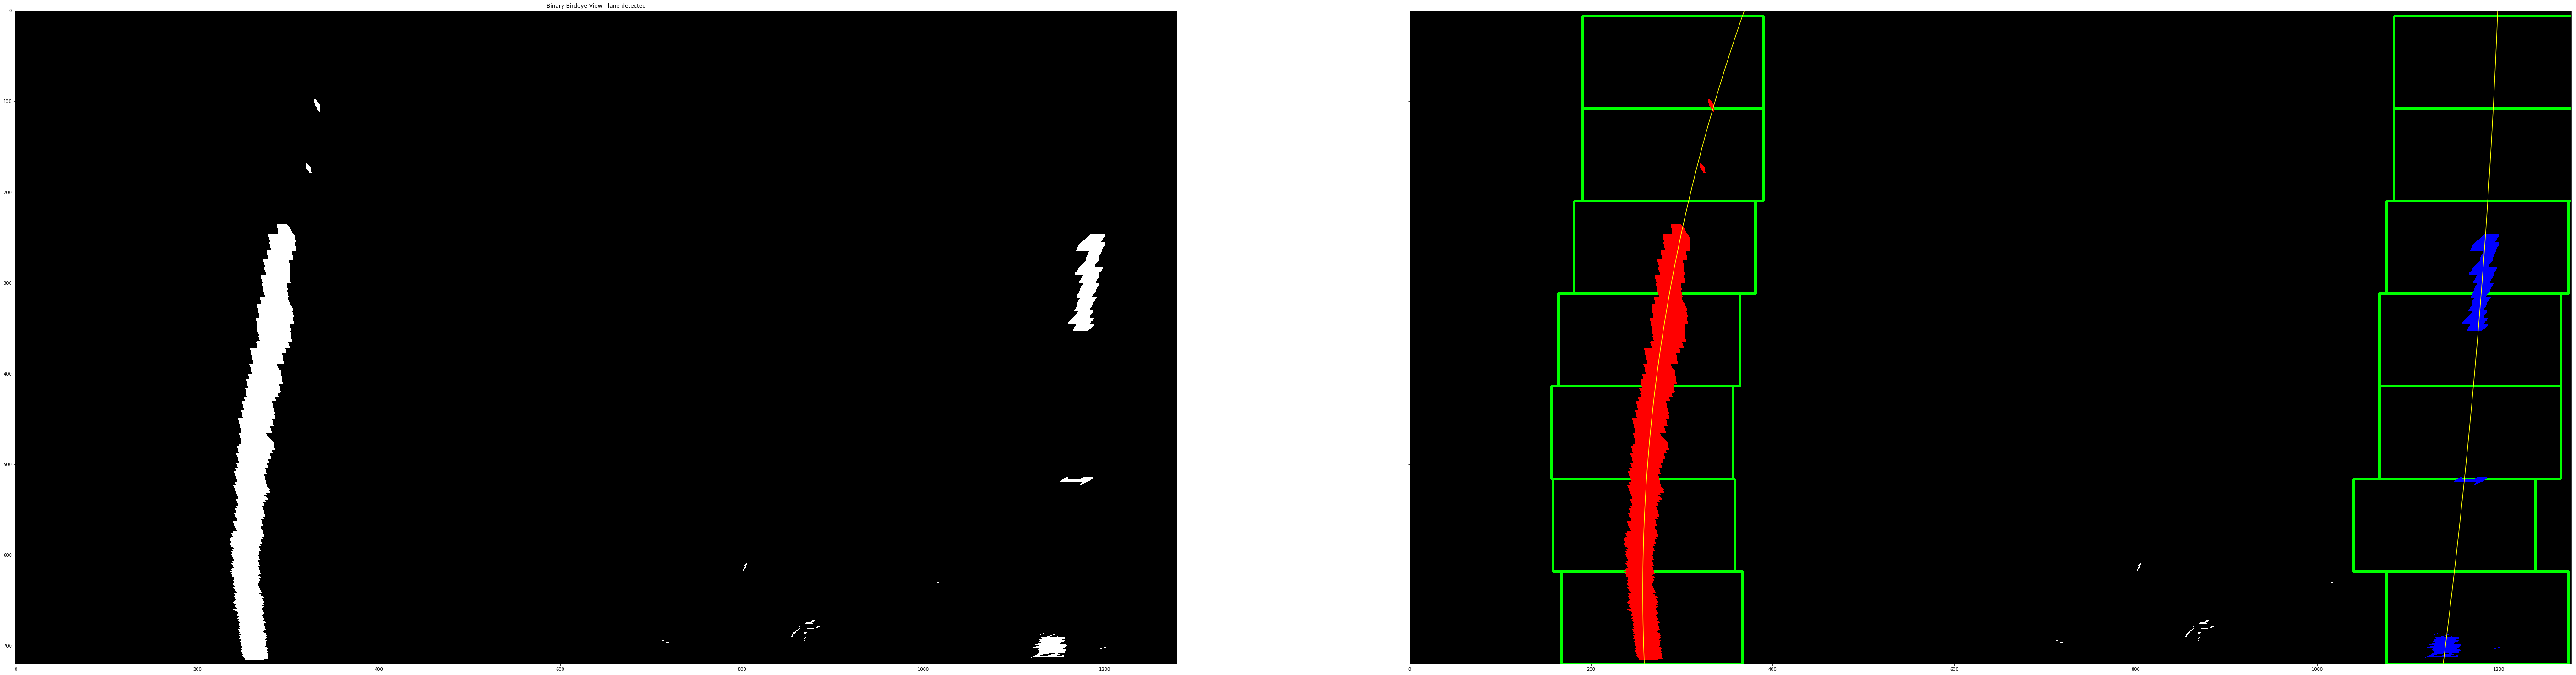

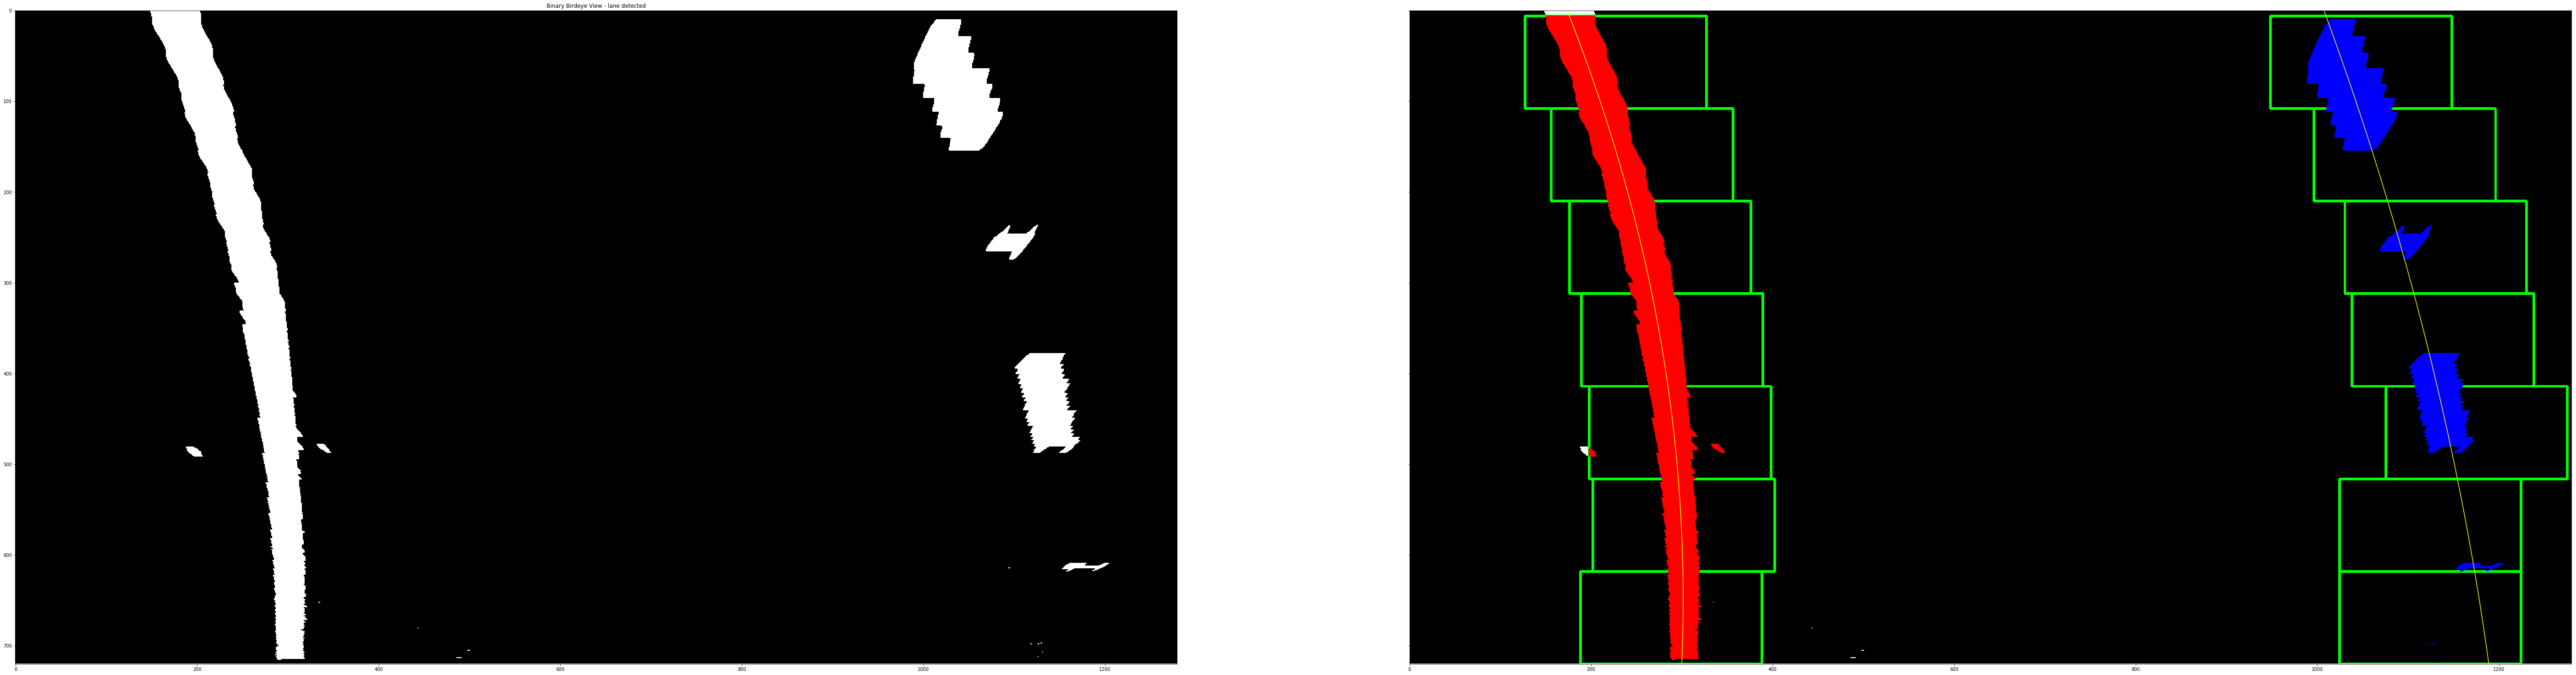

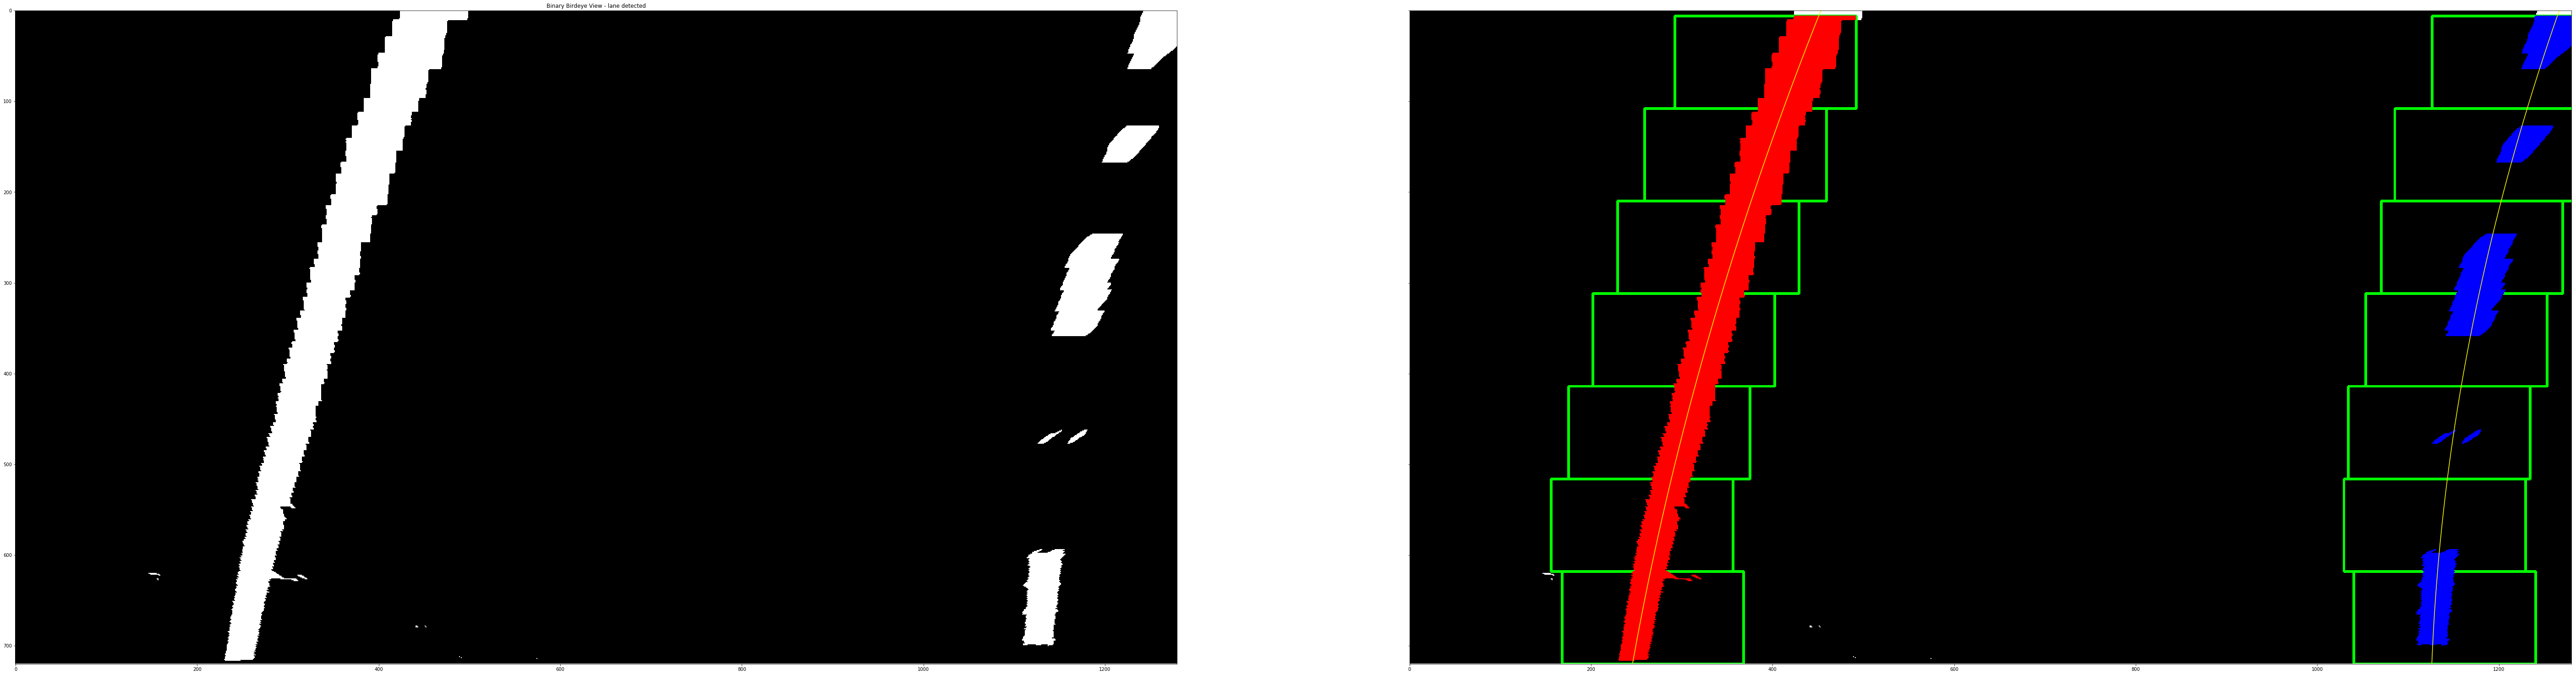

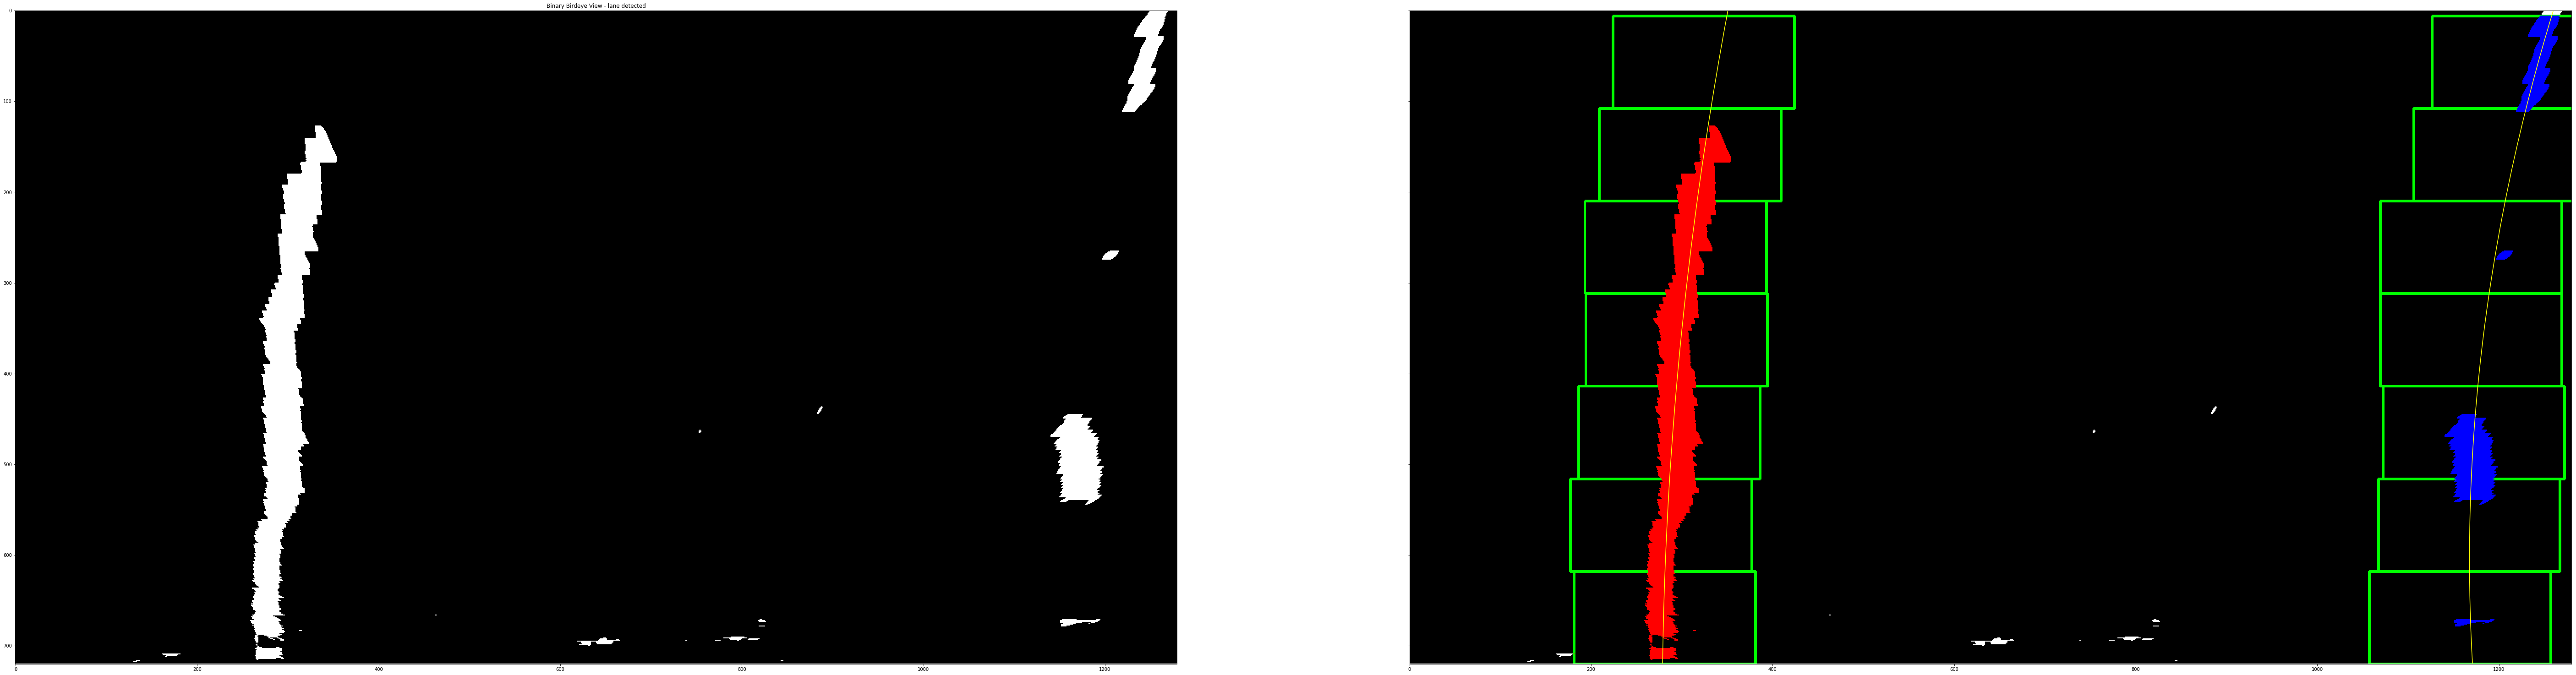

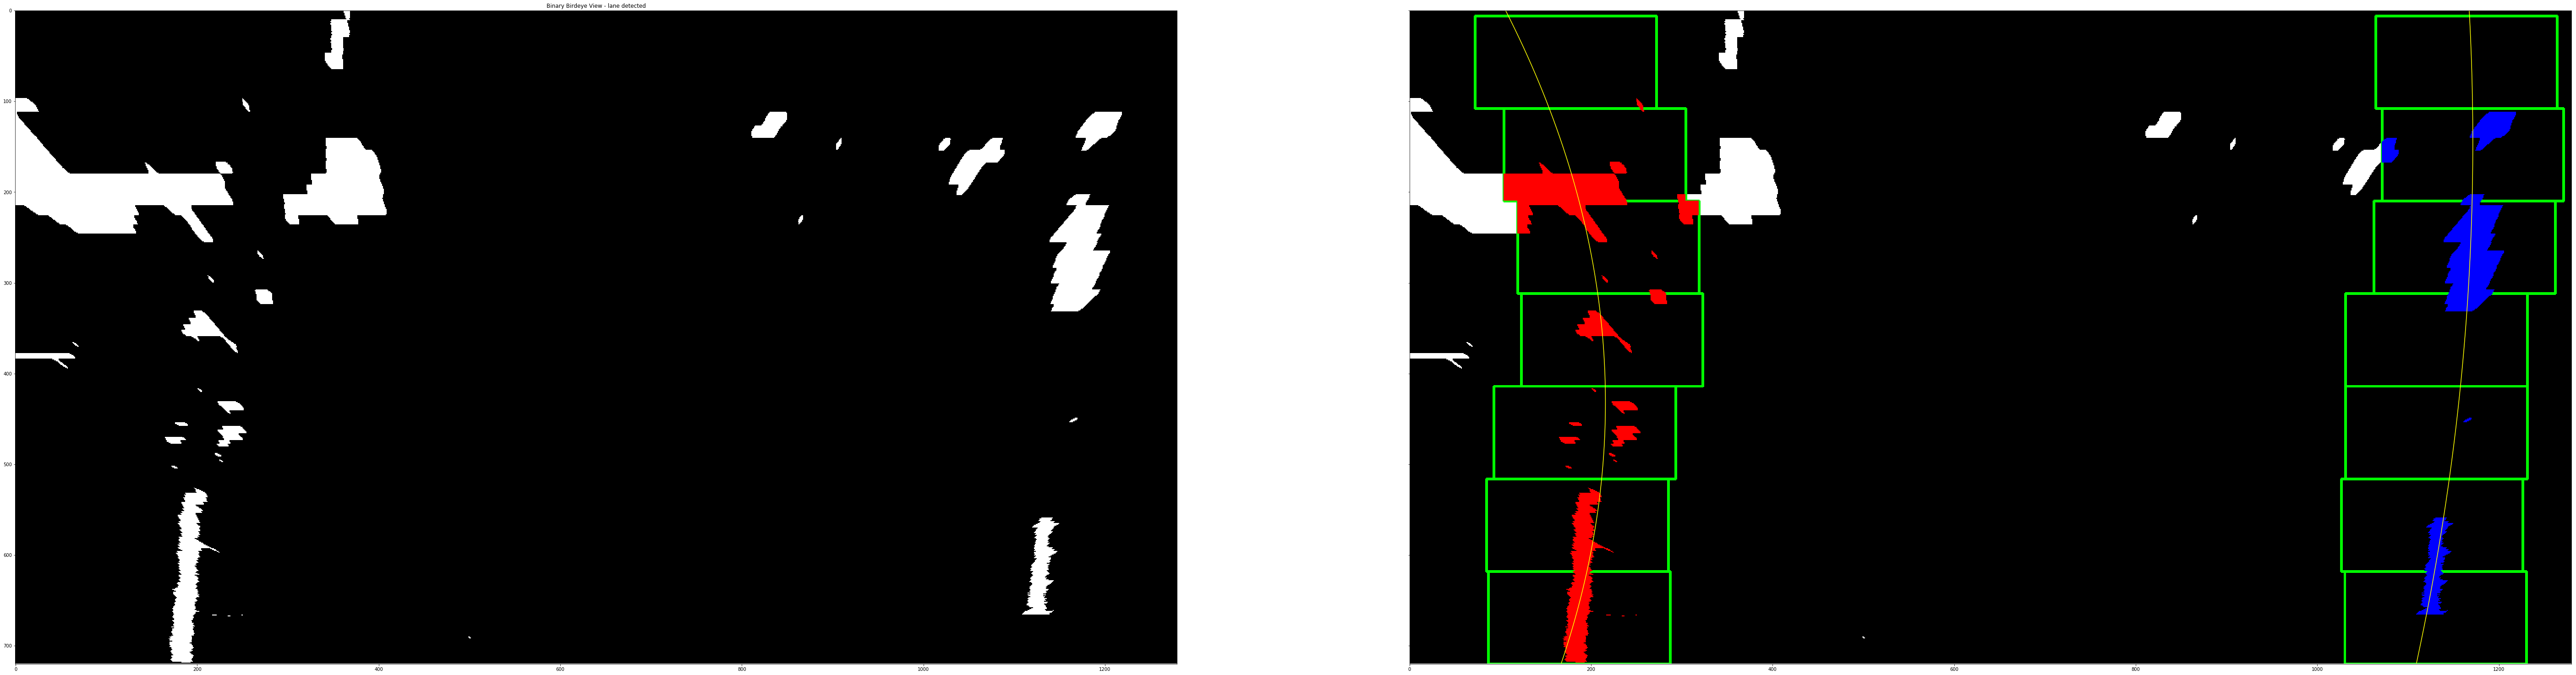

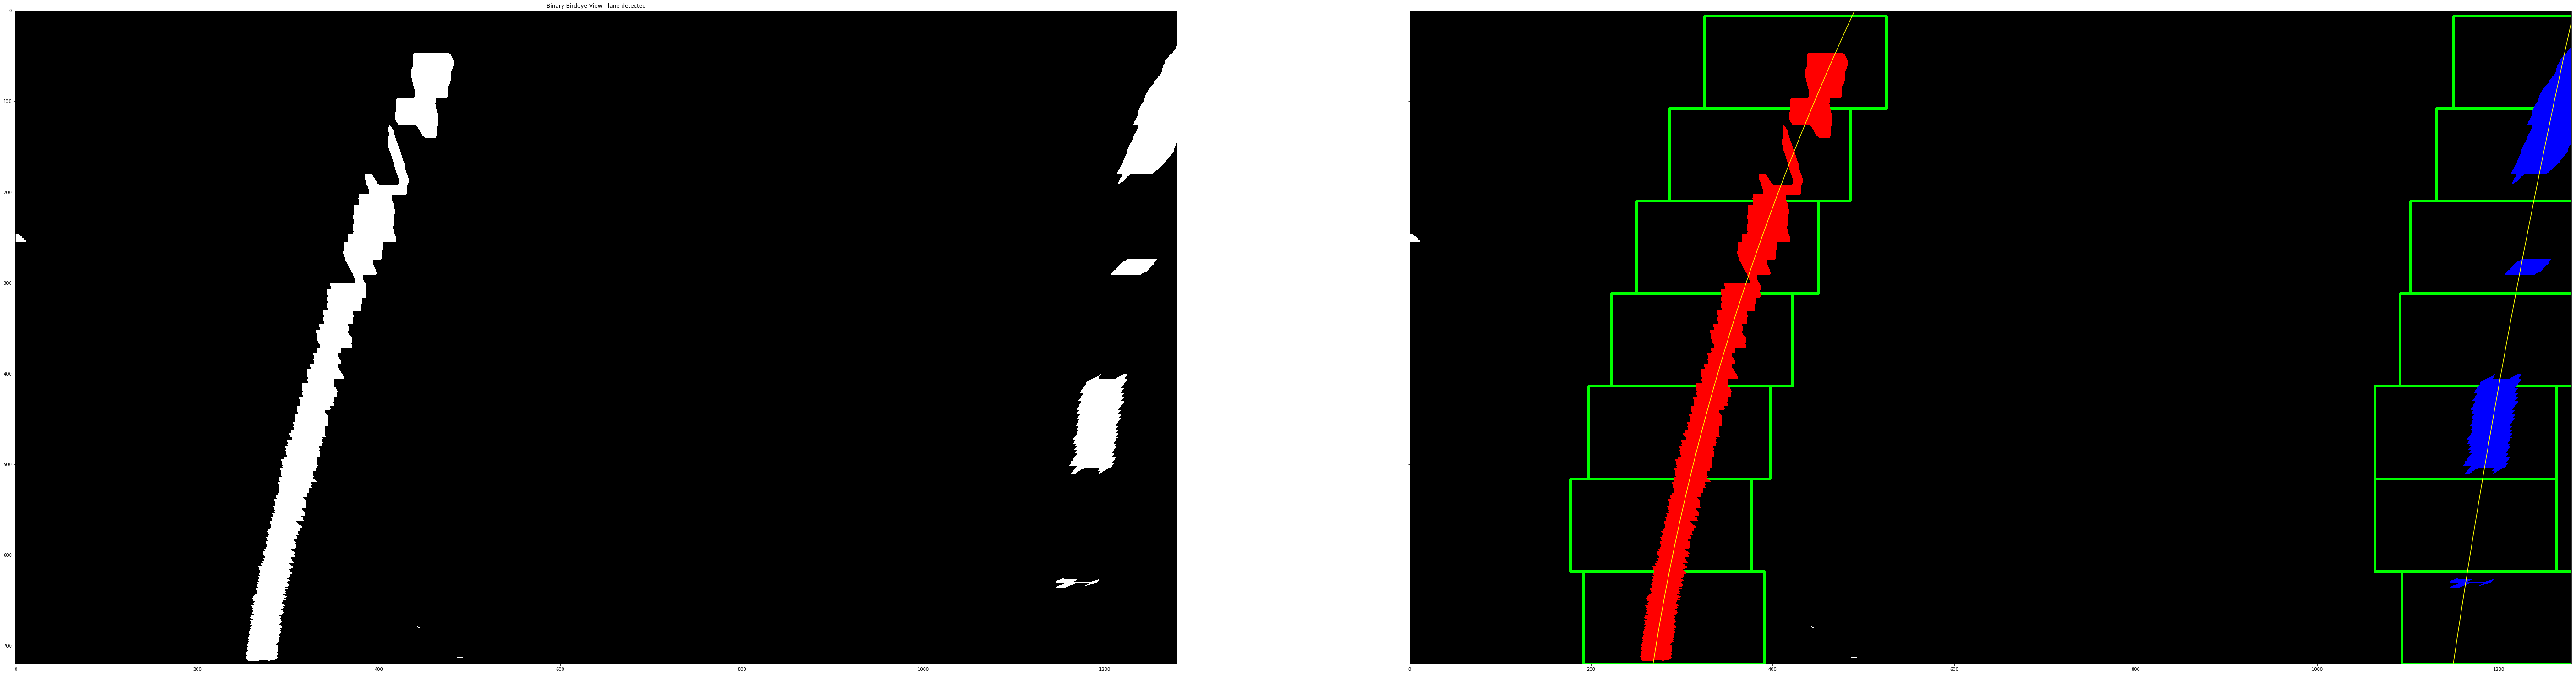

In [14]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 #meters per pixel in x direction

time_window = 10 # the results are averaged over this number of frames

# class to modal a line

class Line:
    """
    Class to model a lane-line.
    """
    def __init__(self, buffer_len=10):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None
        
    def update_line(self,new_fit_pixel,new_fit_meter,detected,clear_buffer=False):
        #clear buffer to reset the buffer
        self.detected = detected
        
        if clear_buffer:
            self.recent_fits_pixel=[]
            self.recent_fits_meter=[]
        
        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter
        
        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)
        
    def draw(self,mask,color=(255,0,0),line_width=50,average=False):
        h,w,c = mask.shape
        
        ploy_y = np.linespace(0,h-1,h)
        coeffs = self.average_fit if average else self.last_fit_pixel
        
        line_center = coeffs[0]*plot_y**2+coeffs[1]*plot_y+coeffs[2]
        line_left_side = line_center - line_width //2
        line_right_side = line_center + line_width//2
        
        # recasting x and y points to fir into cv2.fillploy() format
        plt_left = np.array(list(zip(line_left_side,plot_y)))
        # Flip array in the up/down direction.
        plt_right = np.array(np.flipud(list(zip(line_right_side,plot_y))))
        # np.vstack make a single array vertically
        pts = np.vstack([pys_left,pts_right])
        
        # Draw the lane on the wraped blank image
        return cv2.fillPoly(mask,np[int32(pts)],color)
    
    #averrage of polynomial coefficient of the last n iteration
    def average_fit(self):
        return np.mean(self.recent_fits_pixel,axis=0)
    
    #https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/curvature/v/curvature-formula-part-1
    #radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        curvature_p = (1+(2*coeffs[0]*y_eval+coeffs[1])**2)**1.5 / np.absolute(2*coeffs[0])
        return curvature_p
    
    # radius of the curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter,axis=0)
        curvature_m = (1+(2*coeffs[0]*y_eval+coeffs[1])**2)**1.5 / np.absolute(2*coeffs[0])
        return curvature_meter
    
def get_fits_by_sliding_windows(birdeye_binary,line_lt,line_rt,n_windows=9,verbose=False):

    height,width = birdeye_binary.shape

    # take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary[height//2:-30,:],axis=0)

    #create an output image to draw on and visualize the result
    out_img = np.dstack((birdeye_binary,birdeye_binary,birdeye_binary)) * 255
    #starting points for left and right lines
    midpoint = len(histogram)//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint

    # set height of windows
    window_height = np.int(height/n_windows)

    #identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    # x and y values are used for the identifying the nonzero values in the window
    #NOTE:Returns a tuple of arrays, one for each dimension 
    #of a, containing the indices of the non-zero elements 
    #in that dimension.
    #returned in row-major, C-style order
    nonzero_y = np.array(nonzero[0]) 
    nonzero_x = np.array(nonzero[1])

    #current position to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    margin = 100 #width of the window +/-margin
    minpix = 50 #minimum number of pixel found to recenter window

    #step through the window one by one
    for window in range(n_windows):
        #identify window boundaries in x and y and right and left
        #here height is the height of the binary_wrapped 
        win_y_low = height-(window+1)*window_height
        win_y_high = height-window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current +margin

        # Draw the window onthe visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)

        # identify the non-zeros pixel in x and y within the window

        good_left_inds = ((nonzero_y>=win_y_low)&(nonzero_y<win_y_high)&(nonzero_x >= win_xleft_low)
                         &(nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low)&(nonzero_y<win_y_high)&(nonzero_x >= win_xright_low)
                          &(nonzero_x<win_xright_high)).nonzero()[0]

        #append these nonzero indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # if nonzero values found within the minimum pixel range recenter to their mean int position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))


    #concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    #extracting the left and right pixel positions
    #initialize the all_x and all_y are none in the declaration
    #all_x and all_y to store the (x,y) of the line detected
    line_lt.all_x,line_lt.all_y = nonzero_x[left_lane_inds],nonzero_y[left_lane_inds]
    line_rt.all_x,line_rt.all_y = nonzero_x[right_lane_inds],nonzero_y[right_lane_inds]

    #here the nonzero points detected changes true
    detected = True
    #to check the break of line on the road 
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y,line_lt.all_x,2)
        left_fit_meter = np.polyfit(line_lt.all_y*ym_per_pix,line_lt.all_x*xm_per_pix,2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y,line_rt.all_x,2)
        right_fit_meter = np.polyfit(line_rt.all_y*ym_per_pix,line_rt.all_x*xm_per_pix,2)

    #update left and right fit pixels and meter values
    line_lt.update_line(left_fit_pixel,left_fit_meter,detected=detected)
    line_rt.update_line(right_fit_pixel,right_fit_meter,detected=detected)

    #gernerate x and y values for plotting
    ploty = np.linspace(0,height-1,height)
    left_fitx = left_fit_pixel[0]*ploty**2+left_fit_pixel[1]*ploty+left_fit_pixel[2]
    right_fitx = right_fit_pixel[0]*ploty**2+right_fit_pixel[1]*ploty+right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds],nonzero_x[left_lane_inds]] = [255,0,0]
    out_img[nonzero_y[right_lane_inds],nonzero_x[right_lane_inds]] = [0,0,255]

    if verbose:
        f = plt.figure(figsize=(100,35))
        ax1, ax2 = f.subplots(1, 2, sharex='col', sharey='row')
        f.set_facecolor('white')
        ax1.imshow(birdeye_binary,cmap='gray')
        ax1.set_title('Binary Birdeye View')
        ax2.imshow(out_img)
        ax2.plot(left_fitx,ploty,color='yellow')
        ax2.plot(right_fitx,ploty,color='yellow')
        ax2.set_xlim(0,1280)
        ax2.set_ylim(720,0)
        ax1.set_title('Binary Birdeye View - lane detected')

        plt.show()

    return line_lt,line_rt,out_img
    
#polynomial coeffient for detected lane-lines in binary image

def get_fits_by_previous_fits(birdeye_binary,line_lt,line_rt,verbose=False):

    height,width = birdeye_binary.shape

    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel

    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    margin = 100
    left_lane_inds = ((nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) +
                                    left_fit_pixel[1] * nonzero_y + left_fit_pixel[2]- margin)) & 
                      (nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + 
                                    left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = ((nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + 
                                     right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & 
                       (nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + 
                                     right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    #extract left and right line pixel positions
    line_lt.all_x,line_rt.all_y = nonzero_x[left_lane_inds],nonzero_y[left_lane_inds]
    line_rt.all_x.line_rt.all_y = nonzero_x[right_lane_inds],nonzero_y[left_lane_inds]


    detected = True
    # if none is in the lists then load load previous value to the list
    # else ployfit pixels and meter value
    #polyfit returns a vector of coefficients p that minimises 
    #the squared error
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = left_lt.last_fit_pixel
        left_fit_meter = left_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y,line_lt.all_x,2)
        left_fit_meter = np.polyfit(line_lt.all_y*ym_per_pix,line_lt.all_y*xm_per_pix,2)

    if not list(line_rt.all_x) or not list(linne_rt.all_y):
        right_fit_pixel = right_rt.last_fit_pixel
        right_fit_meter = right_rt.last_fit_meter
        detected = False

    else:
        right_fit_pixel = np.polyfit(line_rt.all_y,line_rt.all_x,2)
        right_fit_meter = np.polyfit(line_rt.all_y*ym_per_pix,line_rt.all_y*xm_per_pix,2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)

    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    #create an image to draw on and an image to show the selection window

    img_fit = np.dstack((birdeye_binary,birdeye_binry,birdeye_binary))*255
    window_img = np.zeros_like(img_fit)

    # color in left and right pixels
    img_fit[nonzero_y[left_lane_inds],nonzero_x[left_lane_inds]] = [255,0,0]
    img_fit[nonzero_y[right_lane_inds],nonzero_x[right_lane_inds]] = [0,0,255]

    #Generate a polygon to illustrate the search window area
    #and recast the x and y points usable format for cv2.fillPoly()

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
    left_line_window2 = np.array(np.flipud([np.transpose(np.vstack([left_fitx+margin,ploty]))]))
    left_line_pts = np.hstack((left_line_window1,left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
    right_line_window2 = np.array([np.transpose(np.flipud(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1,right_line_window2))

    #Draw the lane onto the wraped blank image
    cv.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
    cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
    result = cv2.addWeighted(img_fit,1,window_img,0.3,0)

    if verbose:
        plt.imshow(result)
        plt.plot(left_fitx,ploty,color='yellow')
        plt.plot(right_fitx,ploty,color='yellow')
        plt.xlim(0,1280)
        plt.ylime(720,0)

        plt.show()

    return line_lt,line_rt,img_fit

def draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    #Draw both the drivable lane area and the detected 
    #lane-lines onto the original (undistorted) frame


    height, width, _ = img_undistorted.shape

    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    # Warp back to original image space
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))

    #addweighted to the dewraped image and original image
    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(0, 0, 255), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)

    return blend_onto_road

if __name__=='__main__':
    
    line_lt,line_rt = Line(buffer_len=10),Line(buffer_len=10)
    ret, mtx, dist, rvecs, tvecs = camera_calibration()
    
    # show result on test images
    for test_img in glob.glob('test_images/*.jpg'):

        img = cv2.imread(test_img)

        img_undistorted = undistort(img, mtx, dist, verbose=False)

        img_binary = binary_threshold(img_undistorted, verbose=False)

        img_birdeye, M, Minv = birdeyeview(img_binary, verbose=False)

        line_lt, line_rt, img_out = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, verbose=True)      
        
    